In [1]:
pip install raidionicsmaps@git+https://github.com/raidionics/raidionics_maps.git@master#raidionicsmaps

  Cloning https://github.com/raidionics/raidionics_maps.git (to revision master) to /home/dbouget/.tmp/pip-install-x592eqip/raidionicsmaps_774937f518ab493c8500e52b355d1444
  Running command git clone --filter=blob:none --quiet https://github.com/raidionics/raidionics_maps.git /home/dbouget/.tmp/pip-install-x592eqip/raidionicsmaps_774937f518ab493c8500e52b355d1444
  Resolved https://github.com/raidionics/raidionics_maps.git to commit 1dab4f90a8baf0d17b25df09f8e20541a6e0ae24
  Preparing metadata (setup.py) ... done
  Using cached antspyx-0.3.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (326.3 MB)
  Using cached pillow-10.2.0-cp310-cp310-manylinux_2_28_x86_64.whl (4.5 MB)
  Using cached scikit_learn-1.4.0-1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Using cached matplotlib-3.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached scikit_image-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.7 M

In [4]:
#Download the test data
import os
import requests
import zipfile

test_data_url = 'https://github.com/raidionics/Raidionics-models/releases/download/1.2.0/Samples-RaidionicsMaps-UnitTest1.zip'

test_dir = os.path.join(os.getcwd(), 'unit_tests_results_dir')
os.makedirs(test_dir, exist_ok=True)

archive_dl_dest = os.path.join(test_dir, 'unittest1_data.zip')
if not os.path.exists(archive_dl_dest):
    headers = {}
    response = requests.get(test_data_url, headers=headers, stream=True)
    response.raise_for_status()
    if response.status_code == requests.codes.ok:
        with open(archive_dl_dest, "wb") as f:
            for chunk in response.iter_content(chunk_size=1048576):
                f.write(chunk)
    with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
        zip_ref.extractall(test_dir)

assert(os.path.exists(os.path.join(test_dir, 'Cohort_UnitTest1')))
print("Downloaded data available in {}".format(os.path.join(test_dir, 'Cohort_UnitTest1')))

Downloaded data available in /home/dbouget/Code/Private/raidionics_maps/notebooks/unit_tests_results_dir/Cohort_UnitTest1


In [5]:
import configparser
import os
import warnings
import logging

# Ignore all warnings
warnings.filterwarnings("ignore")
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

test_dir = os.path.join(os.getcwd(), 'unit_tests_results_dir')

test_config = configparser.ConfigParser()
test_config.add_section('Default')
test_config.set('Default', 'task', 'heatmap')
test_config.set('Default', 'input_folder', os.path.join(test_dir, 'Cohort_UnitTest1'))
test_config.set('Default', 'output_folder', os.path.join(test_dir, 'Cohort_UnitTest1_Output'))
test_config.add_section('Maps')
test_config.set('Maps', 'gt_files_suffix', 'label_tumor.nii.gz')
test_config.set('Maps', 'use_registered_data', 'true')
test_config_filename = os.path.join(test_dir, 'unit_test_config.ini')
with open(test_config_filename, 'w') as outfile:
    test_config.write(outfile)

print("Running the heatmap generation unit test.\n")
from raidionicsmaps.compute import compute
compute(test_config_filename)

Running the heatmap generation unit test.



INFO:root:Computing location heatmap for the complete cohort!
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:root:Collecting data in memory...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.99it/s]
INFO:root:Writing heatmaps to disk
INFO:root:Computed heatmap location with 20 samples.


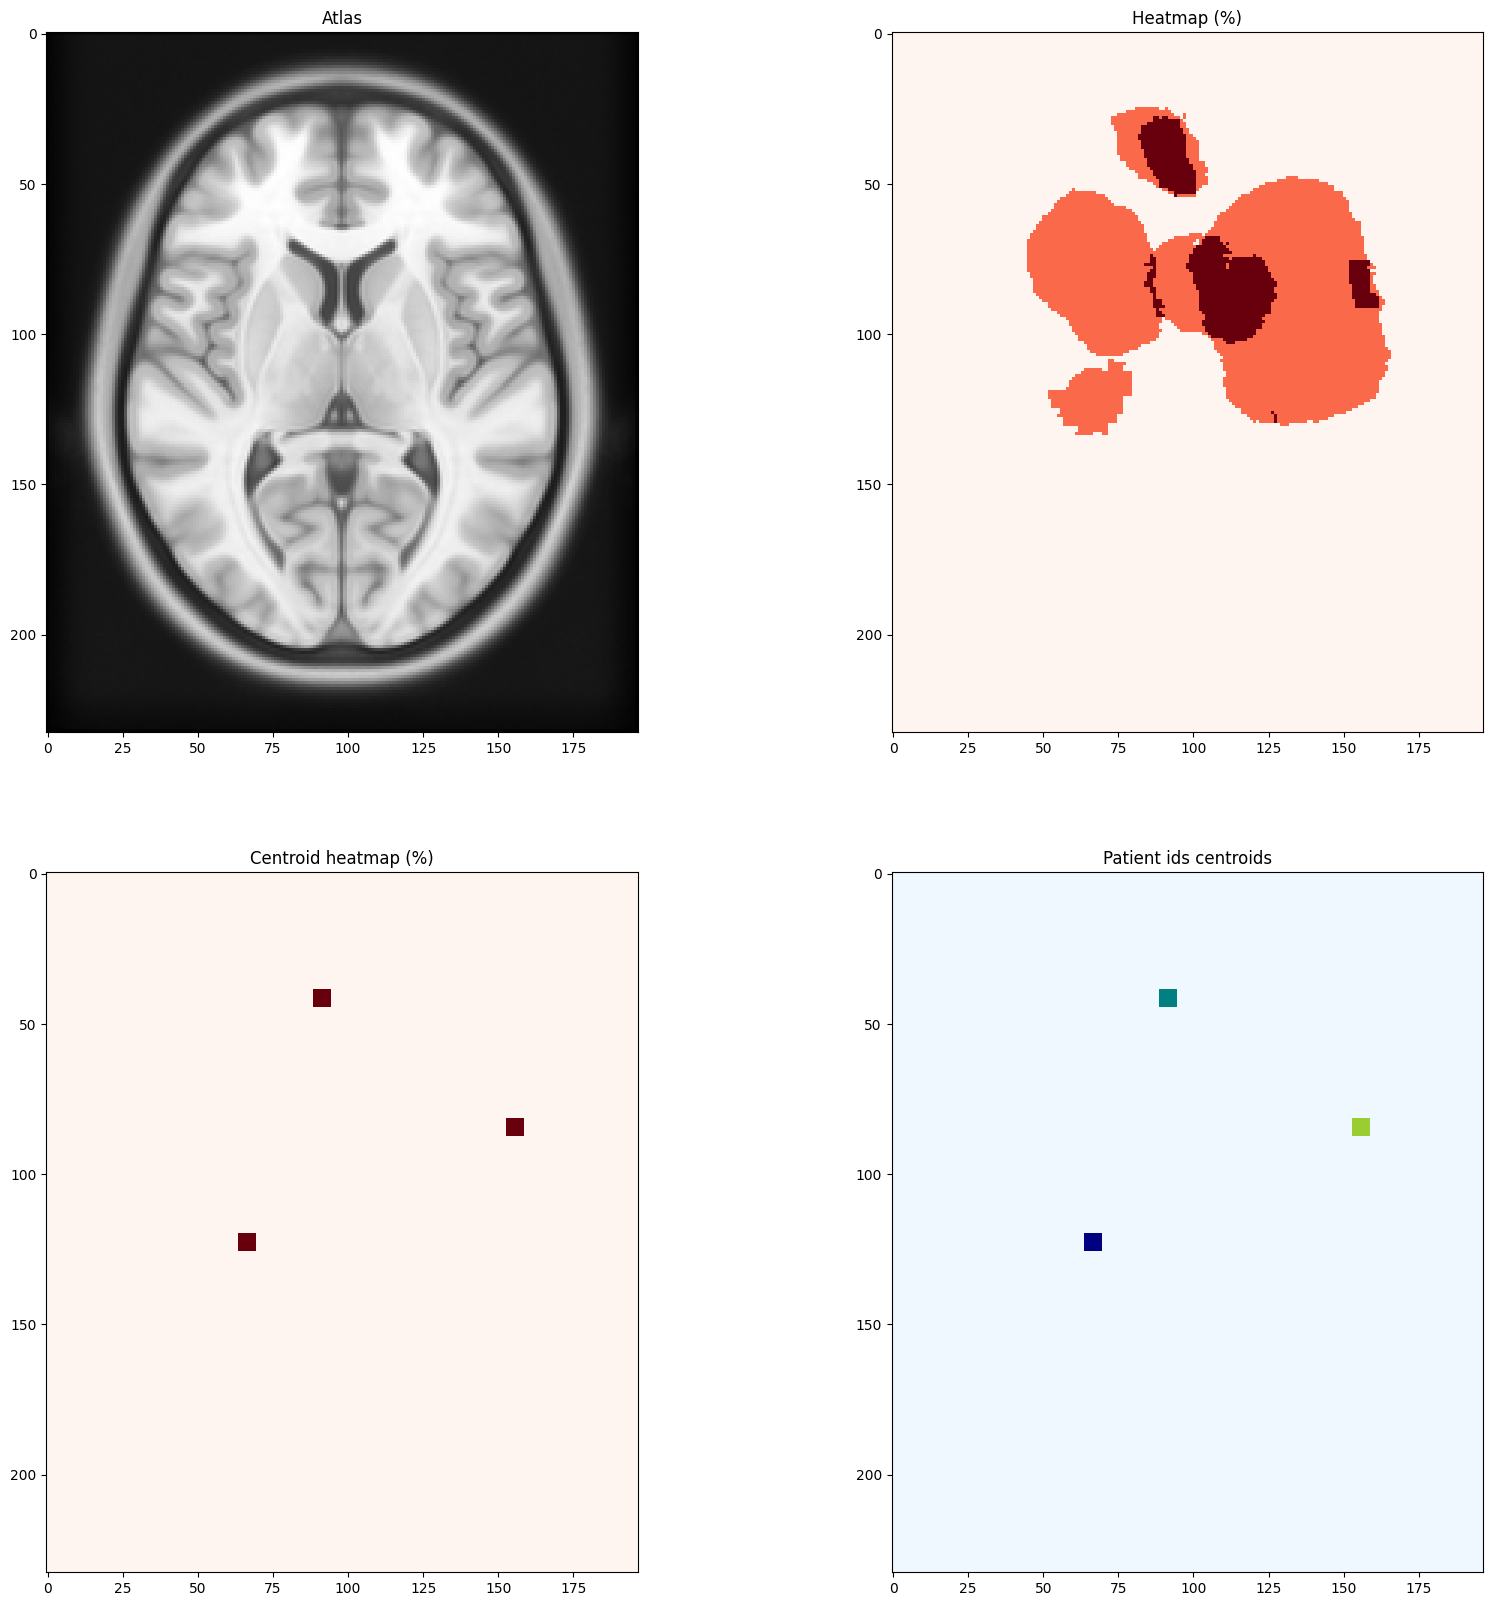

In [31]:
# Inspecting the results
import os
import nibabel as nib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

logging.getLogger().setLevel(logging.WARNING)

# Collecting the generated heatmap
atlas_filename = os.path.join(os.getcwd(), '..', 'raidionicsmaps', 'Atlases', 'mni_icbm152_nlin_sym_09a', 'mni_icbm152_t1_tal_nlin_sym_09a.nii')
heatmap_perc_filename = os.path.join(test_dir, 'Cohort_UnitTest1_Output', 'Heatmaps', 'Overall', 'heatmap_percentages.nii.gz')
heatmap_centroid_perc_filename = os.path.join(test_dir, 'Cohort_UnitTest1_Output', 'Heatmaps', 'Overall', 'heatmap_centroids_percentages.nii.gz')
heatmap_patient_ids_filename = os.path.join(test_dir, 'Cohort_UnitTest1_Output', 'Heatmaps', 'Overall', 'heatmap_patient_ids.nii.gz')

# Loading the generated heatmap
atlas_nib = nib.load(atlas_filename)
heatmap_nib = nib.load(heatmap_perc_filename)
heatmap_centroids_nib = nib.load(heatmap_centroid_perc_filename)
heatmap_patient_ids_nib = nib.load(heatmap_patient_ids_filename)
atlas = atlas_nib.get_fdata()[:]
heatmap = heatmap_nib.get_fdata()[:]
heatmap_centroids = heatmap_centroids_nib.get_fdata()[:]
patient_ids = heatmap_patient_ids_nib.get_fdata()[:]

# Plotting the heatmap for a single 2D slice
cmap = matplotlib.colors.ListedColormap(mcolors.CSS4_COLORS)

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax[0, 0].imshow(np.rot90(atlas[:, :, 79]), cmap="gray")
ax[0, 1].imshow(np.rot90(heatmap[:, :, 79]), cmap="Reds")
ax[1, 0].imshow(np.rot90(heatmap_centroids[:, :, 79]), cmap="Reds")
ax[1, 1].imshow(np.rot90(patient_ids[:, :, 79]), cmap=cmap)

for i, title in enumerate(["Atlas", "Heatmap (%)", "Centroids heatmap (%)", "Patient ids centroids"]):
  ax[int(i/2), i%2].set_title(title)
plt.show()